In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import AFQ.registration as reg
import AFQ.utils.models as ut
import AFQ.data as afd
import AFQ.tractography as aft
import AFQ.csd as csd
import AFQ.dti as dti
import dipy.data as dpd
import nibabel as nib
from AFQ.utils.streamlines import write_trk, read_trk

In [4]:
img, gtab = dpd.read_stanford_hardi()

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/stanford_hardi 


In [4]:
afq_templates = afd.read_templates()

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/AFQ_data/templates 


In [5]:
afq_templates

{'ATR_roi1_L': <nibabel.nifti1.Nifti1Image at 0x11b5865f8>,
 'ATR_roi1_R': <nibabel.nifti1.Nifti1Image at 0x11b59ec88>,
 'ATR_roi2_L': <nibabel.nifti1.Nifti1Image at 0x11b59ea20>,
 'ATR_roi2_R': <nibabel.nifti1.Nifti1Image at 0x11b59eba8>,
 'CGC_roi1_L': <nibabel.nifti1.Nifti1Image at 0x11b586780>,
 'CGC_roi1_R': <nibabel.nifti1.Nifti1Image at 0x11b59ed30>,
 'CGC_roi2_L': <nibabel.nifti1.Nifti1Image at 0x11b586c18>,
 'CGC_roi2_R': <nibabel.nifti1.Nifti1Image at 0x11b586a90>,
 'CST_roi1_L': <nibabel.nifti1.Nifti1Image at 0x11b5a2a58>,
 'CST_roi1_R': <nibabel.nifti1.Nifti1Image at 0x11b5a79b0>,
 'CST_roi2_L': <nibabel.nifti1.Nifti1Image at 0x11b5a7208>,
 'CST_roi2_R': <nibabel.nifti1.Nifti1Image at 0x11b5a2b70>,
 'FA_L': <nibabel.nifti1.Nifti1Image at 0x11b5a7b38>,
 'FA_R': <nibabel.nifti1.Nifti1Image at 0x11b5a2cf8>,
 'FP_L': <nibabel.nifti1.Nifti1Image at 0x11b5a2208>,
 'FP_R': <nibabel.nifti1.Nifti1Image at 0x11b5a7cf8>,
 'HCC_roi1_L': <nibabel.nifti1.Nifti1Image at 0x11b5a2860>,
 'HC

In [6]:
MNI_T2 = dpd.read_mni_template()
MNI_T2_data = MNI_T2.get_data()
MNI_T2_affine = MNI_T2.get_affine()
dwi = img
dwi_affine = dwi.get_affine()
dwi_data = dwi.get_data()
mean_b0 = np.mean(dwi_data[..., gtab.b0s_mask], -1)

Data size is approximately 35MB
Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/mni_template 


In [7]:
warped_b0, mapping = reg.syn_registration(mean_b0, MNI_T2_data,
                                          moving_affine=dwi_affine,
                                          static_affine=MNI_T2_affine,
                                          step_length=0.1,
                                          sigma_diff=2.0,
                                          metric='CC',
                                          dim=3,
                                          level_iters=[10, 10, 5],
                                          prealign=None)

Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
Optimizing level 1
Optimizing level 0


In [8]:
CST_L1 = afq_templates['CST_roi1_L']
CST_L2 = afq_templates['CST_roi2_L']

In [9]:
CST_L1_data = CST_L1.get_data()
CST_L2_data = CST_L2.get_data()

In [10]:
import scipy.ndimage as ndim
def patch_up_roi(roi):
    return ndim.binary_fill_holes(ndim.binary_dilation(roi).astype(int))

In [11]:
warped_CST_L1 = patch_up_roi(mapping.transform_inverse(CST_L1_data, interpolation='nearest'))
warped_CST_L2 = patch_up_roi(mapping.transform_inverse(CST_L2_data, interpolation='nearest'))

In [12]:
#from dipy.segment.mask import median_otsu

In [13]:
#masked_b0, brain_mask = median_otsu(mean_b0)

In [14]:
#plt.matshow(brain_mask[:, :, 40])

In [15]:
#nib.save(nib.Nifti1Image(brain_mask.astype(int), img.affine), 'brain_mask')

In [16]:
#dti.fit_dti(['/Users/arokem/.dipy/stanford_hardi/HARDI150.nii.gz'], 
#            ['/Users/arokem/.dipy/stanford_hardi/HARDI150.bval'], 
#            ['/Users/arokem/.dipy/stanford_hardi/HARDI150.bvec'], 
#            out_dir='.', mask='brain_mask.nii')

In [17]:
#nib.save(nib.Nifti1Image((nib.load('dti_FA.nii.gz').get_data() > 0.2).astype(int), img.affine), 'wm_mask.nii.gz')

In [18]:
#csd.fit_csd(['/Users/arokem/.dipy/stanford_hardi/HARDI150.nii.gz'], 
#            ['/Users/arokem/.dipy/stanford_hardi/HARDI150.bval'], 
#            ['/Users/arokem/.dipy/stanford_hardi/HARDI150.bvec'], 
#            out_dir='.',
#            mask='brain_mask.nii')

In [19]:
import nibabel as nib

In [20]:
#mask = nib.load('wm_mask.nii.gz').get_data()

In [21]:
#csd_coeff = nib.load('csd_sh_coeff.nii.gz').get_data()

In [22]:
localtracking = aft.track('./dti_params.nii.gz', seed_density=[1, 1, 1],
                          seed_mask=nib.load('wm_mask.nii.gz').get_data(), 
                          stop_mask=nib.load('wm_mask.nii.gz').get_data())

write_trk('./dti_streamlines.trk', sl_long)
#localtracking = aft.track('./csd_sh_coeff.nii.gz', seed_density=[1, 1, 1],
#                          seed_mask=nib.load('wm_mask.nii.gz').get_data(), 
#                          stop_mask=nib.load('wm_mask.nii.gz').get_data())

In [23]:
#streamlines = list(localtracking)

In [24]:
#sl_long = [sl for sl in streamlines if sl.shape[0]>3]

In [25]:
#len(sl_long)

In [27]:
#write_trk('./csd_streamlines.trk', sl_long)

In [28]:
streamlines = read_trk('./csd_streamlines.trk')

In [29]:
len(streamlines)

129251

In [30]:
import dipy.tracking.utils as dtu

In [31]:
xform_sl = [s for s in dtu.move_streamlines(streamlines, np.linalg.inv(img.affine))]

In [32]:
import time

In [33]:
import dipy.tracking.streamline as dts

In [34]:
select_sl = xform_sl
ROIs = [warped_CST_L1, warped_CST_L2]
t0 = time.time()
for r in ROIs:
    select_sl = dts.select_by_rois(select_sl, [r.astype(bool)], [True])

select_sl = list(select_sl)
t1 = time.time()
print(t1 - t0)

16.50788402557373


In [35]:
len(select_sl)

488

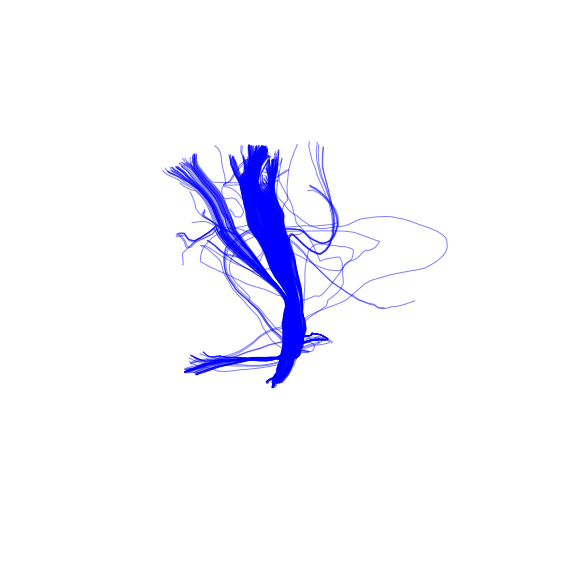

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for s in select_sl:
    ax.plot(s[:, 0], s[:, 1], s[:, 2],color='b', alpha=0.5)

ax.axis("off")
fig.set_size_inches([10, 10])

for ii, angle in enumerate(range(0, 360, 20)):
    ax.view_init(0, angle)
    fig.savefig('/Users/arokem/tmp/cst/img%03d.png'%ii)

In [36]:
## For the corticospinal tract, need to potentially deal with fibers that loop through the brainstem

## Deal with fiber outliers

## Compare with the track probability maps? 